In [1]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath)
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]


  return df

# wrangle
df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

# do test/train split 
# use data from April to May 2016 to train 
# use data from June 2016 to test 
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test = df[df.created > cutoff]

In [9]:
train.describe(include='number')

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,...,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000
mean,1.203728,1.528357,40.750743,-73.972867,3575.604007,0.530430,0.477139,0.480907,0.445861,0.430725,...,0.088620,0.060734,0.055929,0.051470,0.047733,0.042269,0.044216,0.039222,0.028388,0.029048
std,0.472447,1.105061,0.038658,0.028910,1762.136694,0.499081,0.499485,0.499643,0.497068,0.495185,...,0.284198,0.238845,0.229788,0.220957,0.213203,0.201204,0.205577,0.194127,0.166082,0.167943
min,0.000000,0.000000,40.575700,-74.087300,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,40.728500,-73.991800,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.751700,-73.978100,3150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,40.773600,-73.955000,4095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,7.000000,40.910200,-73.700100,15500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train.describe(exclude='number')

<ipython-input-8-43962679779c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(exclude='number')


,created,description,display_address,street_address,interest_level
count,31844,30875,31775,31838,31844
unique,31436,25735,6468,11280,3
top,2016-05-18 01:36:49,,Broadway,505 West 37th Street,low
freq,3,906,273,120,22053
first,2016-04-01 22:12:41,NaN,NaN,NaN,NaN
last,2016-05-31 23:10:48,NaN,NaN,NaN,NaN


Look at the relationship between intrest level and price

In [11]:
train['interest_level'].value_counts()

low       22053
medium     7381
high       2410
Name: interest_level, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


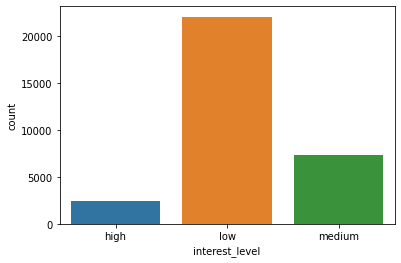

In [17]:
import seaborn as sns
sns.countplot(train['interest_level']);

# II. Split Data

Split **target vector** from **feature matrix**.

In [20]:
target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [29]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [22]:
X_train.shape, X_test.shape

((31844, 29), (16973, 29))

In [30]:
#use Transformer to change data to one-hot-encoded 
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [37]:
# select best features
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [38]:
X_train_selected.shape, X_test_selected.shape

((31844, 15), (16973, 15))

In [44]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
  print(name)

print('\nFeatures unselected:')
for name in unselected_names:
  print(name)


Features selected:
bathrooms
bedrooms
longitude
elevator
doorman
dishwasher
no_fee
fitness_center
laundry_in_unit
roof_deck
dining_room
high_speed_internet
swimming_pool
new_construction
wheelchair_access

Features unselected:
latitude
interest_level_high
interest_level_low
interest_level_medium
cats_allowed
hardwood_floors
dogs_allowed
laundry_in_building
pre-war
outdoor_space
balcony
terrace
exclusive
loft
garden_patio
common_outdoor_space


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):

  print(f'{k} features')
  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $890 

2 features
Test Mean Absolute Error: $826 

3 features
Test Mean Absolute Error: $744 

4 features
Test Mean Absolute Error: $714 

5 features
Test Mean Absolute Error: $714 

6 features
Test Mean Absolute Error: $713 

7 features
Test Mean Absolute Error: $713 

8 features
Test Mean Absolute Error: $713 

9 features
Test Mean Absolute Error: $713 

10 features
Test Mean Absolute Error: $712 

11 features
Test Mean Absolute Error: $709 

12 features
Test Mean Absolute Error: $708 

13 features
Test Mean Absolute Error: $705 

14 features
Test Mean Absolute Error: $705 

15 features
Test Mean Absolute Error: $704 

16 features
Test Mean Absolute Error: $705 

17 features
Test Mean Absolute Error: $679 

18 features
Test Mean Absolute Error: $679 

19 features
Test Mean Absolute Error: $679 

20 features
Test Mean Absolute Error: $676 

21 features
Test Mean Absolute Error: $675 

22 features
Test Mean Absolute Error: $675 

23 features
Test Me

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

**Model 1:** Regular ol' linear regression

**Model 2:** Ridge regression (regularization)

**Model 3:** `SelectKBest`

In [36]:
from sklearn.feature_selection import SelectKBest
# model_lr_skb = 
selector = SelectKBest(k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# V. Check Metrics

# Communicate results